<a href="https://colab.research.google.com/github/Bettinapy/movie-model/blob/master/Movie_Features_and_Cumulated_View_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Load Data**

**1.1 Load Packages**



In [0]:
# Load libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing # use StandardScaler for feature scaling

**1.2 Load Dataset**

In [0]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=13G3aYKWR53edneCqe_o36-7kZNUbYY7H'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('TVdata.txt') 

**1.3 Summarize the Dataset**

Video_id is the unique id of the dataset, cvt_per_day is the target feature, the rest of the columns are categorical/numeric features of different videos.

In [0]:
tv_df = pd.read_csv('TVdata.txt') #read data
tv_df.head() #display the first 5 rows

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


In [0]:
tv_df.info() #data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
video_id                         4226 non-null int64
cvt_per_day                      4226 non-null float64
weighted_categorical_position    4226 non-null int64
weighted_horizontal_poition      4226 non-null int64
import_id                        4226 non-null object
release_year                     4226 non-null int64
genres                           4226 non-null object
imdb_votes                       4226 non-null int64
budget                           4226 non-null int64
boxoffice                        4226 non-null int64
imdb_rating                      4226 non-null float64
duration_in_mins                 4226 non-null float64
metacritic_score                 4226 non-null int64
awards                           4226 non-null object
mpaa                             4226 non-null object
star_category                    4226 non-null float64
dtypes: float64(4), int64(8), obj

In [0]:
print ("Num of rows: " + str(tv_df.shape[0])) # row count
print ("Num of columns: " + str(tv_df.shape[1])) # col count

Num of rows: 4226
Num of columns: 16


# **2. Data Exploration**

**2.1 Duplicates**

In [0]:
# check duplicates: set 'video_id' as index and check duplicates
tv_df_idx_video = tv_df.set_index('video_id')
if len(tv_df_idx_video[tv_df_idx_video.index.duplicated()]) == 0:
  print ('There is no duplicated video_id')

There is no duplicated video_id


**2.2 Understand the numeric features**

2.2.1 Missing values

In [0]:
# basic stats, check missing values
tv_df.drop(['video_id'], axis=1).describe(percentiles = [.1,.25,.5,.75,.95])

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,4226.000000,4226.000000,4226.000000
mean,4218.630239,7.782537,28.103644,2001.056791,6462.924042,2.150743e+06,2.536338e+06,5.257099,89.556123,15.973734,0.954651
std,13036.079964,6.134183,11.863649,17.496849,31596.006790,7.176604e+06,8.243516e+06,2.122810,21.086183,26.205217,0.955045
min,2.187625,1.000000,1.000000,1916.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,4.037250,0.000000,0.000000
10%,141.984913,3.000000,13.000000,1974.000000,8.000000,0.000000e+00,0.000000e+00,2.300000,62.390781,0.000000,0.000000
25%,351.168776,4.000000,20.000000,1998.000000,81.000000,0.000000e+00,0.000000e+00,4.300000,82.601712,0.000000,0.000000
50%,1193.499989,6.000000,28.000000,2008.000000,535.000000,0.000000e+00,0.000000e+00,5.800000,90.730308,0.000000,1.000000
75%,3356.788816,9.000000,36.000000,2012.000000,3053.000000,1.500000e+06,0.000000e+00,6.800000,99.500312,41.000000,1.666667
95%,14692.833929,22.000000,48.000000,2015.000000,26199.500000,1.200000e+07,8.551228e+06,7.800000,119.131183,65.000000,2.597222
max,307127.605608,41.000000,70.000000,2017.000000,948630.000000,1.070000e+08,1.842088e+08,10.000000,246.016767,100.000000,4.000000


In [0]:
# count 0 values
print((tv_df == 0).sum())

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
import_id                           0
release_year                        0
genres                              0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
awards                              0
mpaa                                0
star_category                    1846
dtype: int64


6 numeric features have 0 values. 4 features have over 25% of 0 values: budge, boxoffice, matacritic_score and star_category. 'boxoffice' even has 75% of 0 values. 2 features have over 10% of 0 values: imdb_votes and imdb_rating. 

2.2.2 Target feature: cvt_per_day

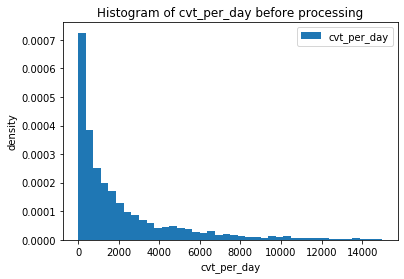

In [0]:
plt.hist(tv_df['cvt_per_day'].values, bins=40, range=(0,15000), density=True, label = 'cvt_per_day')
plt.legend(loc='upper right')
plt.title('Histogram of cvt_per_day before processing')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

2.2.3 Correlation among numerical features

In [0]:
corr_nr = tv_df[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition', 'imdb_votes'
                ,'budget','boxoffice','imdb_rating','duration_in_mins','metacritic_score','star_category']].corr()
corr_nr            

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000000,-0.148000,-0.301663,0.297697,0.315886,0.312209,0.058894,0.152217,0.249159,0.246956
weighted_categorical_position,-0.148000,1.000000,-0.084066,-0.063700,-0.089899,-0.073628,-0.116443,-0.174461,-0.044317,-0.122851
weighted_horizontal_poition,-0.301663,-0.084066,1.000000,-0.220749,-0.211356,-0.244709,-0.162021,-0.102344,-0.255015,-0.167801
imdb_votes,0.297697,-0.063700,-0.220749,1.000000,0.272852,0.531467,0.163264,0.155670,0.321860,0.225192
budget,0.315886,-0.089899,-0.211356,0.272852,1.000000,0.504618,0.105671,0.251342,0.314608,0.321721
boxoffice,0.312209,-0.073628,-0.244709,0.531467,0.504618,1.000000,0.163673,0.226184,0.464965,0.322329
imdb_rating,0.058894,-0.116443,-0.162021,0.163264,0.105671,0.163673,1.000000,0.344055,0.346935,0.191768
duration_in_mins,0.152217,-0.174461,-0.102344,0.155670,0.251342,0.226184,0.344055,1.000000,0.327050,0.309110
metacritic_score,0.249159,-0.044317,-0.255015,0.321860,0.314608,0.464965,0.346935,0.327050,1.000000,0.452445
star_category,0.246956,-0.122851,-0.167801,0.225192,0.321721,0.322329,0.191768,0.309110,0.452445,1.000000


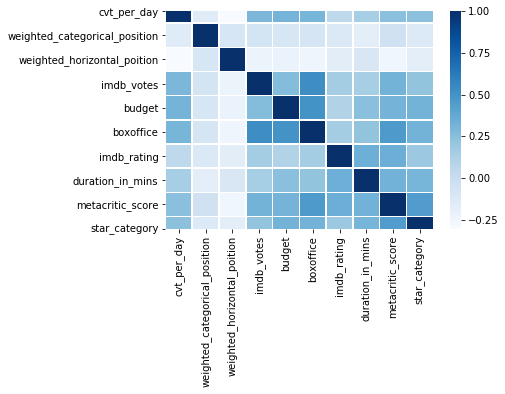

In [0]:
# plot the correlation matrix
sns.heatmap(corr_nr, cmap = "Blues", linewidths=.5)
plt.show()

**2.3 Understand the categorical features**


2.3.1 Simple features

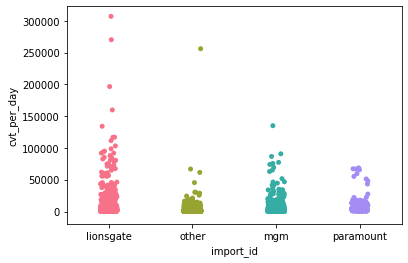

       index  import_id
0      other       2963
1  lionsgate        677
2        mgm        445
3  paramount        141


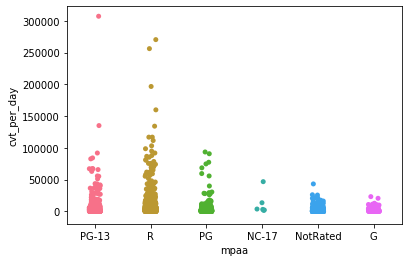

      index  mpaa
0  NotRated  2158
1         R  1158
2     PG-13   426
3        PG   353
4         G   125
5     NC-17     6


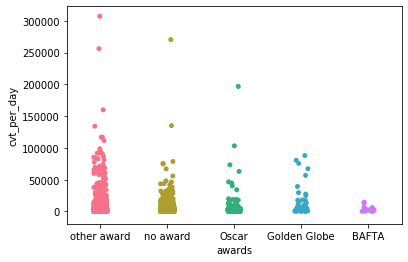

          index  awards
0      no award    2569
1   other award    1453
2         Oscar     141
3  Golden Globe      44
4         BAFTA      19


In [0]:
# use stripplot to show the distribution, boxplot is another choice
sns.stripplot(x='import_id', y ='cvt_per_day', data=tv_df, palette="husl")
plt.show()
# print the value, reset the index of the DataFrame, and use the default one instead.
print(tv_df['import_id'].value_counts().reset_index())

sns.stripplot(x='mpaa', y ='cvt_per_day', data=tv_df, palette="husl")
plt.show()
print(tv_df['mpaa'].value_counts().reset_index())

sns.stripplot(x='awards', y ='cvt_per_day', data=tv_df, palette="husl")
plt.show()
print(tv_df['awards'].value_counts().reset_index())

2.3.2 Genre feature

There are some comma separated values in 'genre' column, split the column value and apply one hot encoding

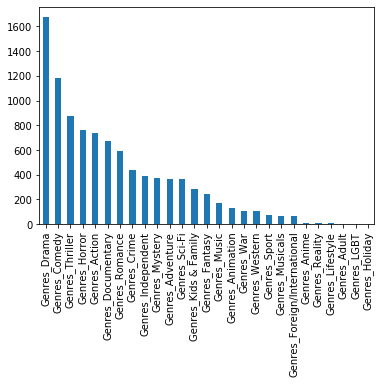

In [0]:
# convert genres variable into dummy/indicator variables
d_genre = tv_df['genres'].str.get_dummies(sep=',').rename(columns=lambda x: 'Genres_' + str(x))
# calculate the sum 
d_genre_sum = d_genre.sum()
# plot the genre dummy sum
d_genre_sum.sort_values(ascending = False).plot.bar()


From the bar plot, we notice that there are some features with extremely low frequencies including genres_anime, reality, lifestyle, adult, LGBT and holiday. We can group those "rare features" together. 

2.3.3 Release_year feature

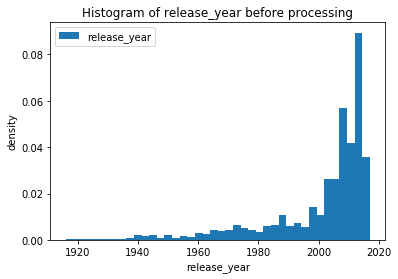

count    4226.000000
mean     2001.056791
std        17.496849
min      1916.000000
10%      1974.000000
20%      1991.000000
30%      2001.000000
40%      2006.000000
50%      2008.000000
60%      2010.000000
70%      2012.000000
80%      2013.000000
90%      2014.000000
max      2017.000000
Name: release_year, dtype: float64


In [0]:
# plot release_year histogram
plt.hist(tv_df['release_year'].values, bins=40, range=(1916,2017), density=True, label = 'release_year')
plt.legend(loc='upper left')
plt.title('Histogram of release_year before processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

# divide release_year into 10 percentiles
print(tv_df['release_year'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]))

# **3. Feature Preprocessing**

**3.1 Categorial features**

In the tv dataset, there are 5 categorical viriables: release_year, genres, import_id, mpaa and awards.
We can easily convert import_id, mpaa and awards into dummy features.
For genre feature, we need to group 6 'rare features' at first.
For release_year feature, we need to bin it into 10 buckets.

In [0]:
# convert import_id, mpaa and awards into dummy features
d_import_id = pd.get_dummies(tv_df['import_id'], dtype=np.int64).rename(columns=lambda x: 'import_id_' + str(x))
d_mpaa = pd.get_dummies(tv_df['mpaa'], dtype=np.int64).rename(columns=lambda x: 'mpaa_' + str(x))
d_awards = pd.get_dummies(tv_df['awards'], dtype=np.int64).rename(columns=lambda x: 'awards_' + str(x))

In [0]:
# combine 6 genre 'rare features' into a new feature 'Genres_comb', then drop those 6 genres
d_genre['Genres_comb'] = d_genre['Genres_Anime']|d_genre['Genres_Reality']|d_genre['Genres_Lifestyle']|d_genre['Genres_Adult']|d_genre['Genres_LGBT']|d_genre['Genres_Holiday']
d_genre.drop(['Genres_Anime','Genres_Reality','Genres_Lifestyle','Genres_Adult','Genres_LGBT','Genres_Holiday'], axis =1, inplace=True)
d_genre.head()

,Genres_Action,Genres_Adventure,Genres_Animation,Genres_Comedy,Genres_Crime,Genres_Documentary,Genres_Drama,Genres_Fantasy,Genres_Foreign/International,Genres_Horror,Genres_Independent,Genres_Kids & Family,Genres_Music,Genres_Musicals,Genres_Mystery,Genres_Romance,Genres_Sci-Fi,Genres_Sport,Genres_Thriller,Genres_War,Genres_Western,Genres_comb
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [0]:
# Bin 'release_year' into 10 groups of year range
bins_year = [1916,1974,1991,2001,2006,2008,2010,2012,2013,2014,2017]
labels_year = ['1916-1974', '1974-1991', '1991-2001','2001-2006','2006-2008', '2008-2010', '2010-2012', '2012-2013', '2013-2014', '2014-2017']
year_bins = pd.cut(tv_df['release_year'], bins_year, labels = labels_year)
# convert year range into dummy variables
d_release_year = pd.get_dummies(year_bins, dtype=np.int64).rename(columns=lambda x: 'release_' + str(x))


In [0]:
# concatenate dummy variables with tv_df and drop the categorical features
tv_df_drop = tv_df.drop(['import_id','mpaa','awards','genres','release_year'], axis =1)
d_tv_df = pd.concat([tv_df_drop, d_import_id, d_mpaa, d_awards, d_genre, d_release_year], axis =1)
print(d_tv_df.shape)
# find whether there's any null value in the new tv_df
# any(1): 1 means column
# to_numpy().nonzero() is used to find the indices of an array, where a condition is True
print (pd.isnull(d_tv_df).any(1).to_numpy().nonzero())
print (d_tv_df.head())

(4226, 58)
(array([], dtype=int64),)
   video_id    cvt_per_day  ...  release_2013-2014  release_2014-2017
0    385504  307127.605608  ...                  0                  0
1    300175  270338.426375  ...                  0                  0
2    361899  256165.867446  ...                  0                  0
3    308314  196622.720996  ...                  0                  0
4    307201  159841.652064  ...                  0                  0

[5 rows x 58 columns]


**3.2 Handling Missing Values**

From our analysis on numeric features, we found that 6 numeric features have 0 values. 4 features have over 25% of 0 values: budge, boxoffice, matacritic_score and star_category. 'boxoffice' even has 75% of 0 values. 2 features have over 10% of 0 values: imdb_votes and imdb_rating. 

In [0]:
# mark all of the missing value as NaN and count the NaN values in each column
d_tv_df[["imdb_votes","budget","boxoffice","imdb_rating","metacritic_score","star_category"]] = d_tv_df[["imdb_votes","budget","boxoffice","imdb_rating","metacritic_score","star_category"]].replace(0,np.NaN)
print(d_tv_df.isnull().sum())

# count the number of videos which have at least one NaN value
print ( d_tv_df.isnull().any(1).sum(),'videos have at least one NaN value')

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
star_category                    1846
import_id_lionsgate                 0
import_id_mgm                       0
import_id_other                     0
import_id_paramount                 0
mpaa_G                              0
mpaa_NC-17                          0
mpaa_NotRated                       0
mpaa_PG                             0
mpaa_PG-13                          0
mpaa_R                              0
awards_BAFTA                        0
awards_Golden Globe                 0
awards_Oscar                        0
awards_no award                     0
awards_other award                  0
Genres_Actio

3.2.1 Fill missing values with mean

In [0]:
fm_tv_df = d_tv_df.copy()
# fill missing values with mean column values
fm_tv_df['imdb_votes'].fillna(fm_tv_df['imdb_votes'].mean(), inplace=True)
fm_tv_df['budget'].fillna(fm_tv_df['budget'].mean(), inplace=True)
fm_tv_df['boxoffice'].fillna(fm_tv_df['boxoffice'].mean(), inplace=True)
fm_tv_df['imdb_rating'].fillna(fm_tv_df['imdb_rating'].mean(), inplace=True)
fm_tv_df['metacritic_score'].fillna(fm_tv_df['metacritic_score'].mean(), inplace=True)
fm_tv_df['star_category'].fillna(fm_tv_df['star_category'].mean(), inplace=True)
# count the number of NaN values in each column
print(fm_tv_df.isnull().sum())

video_id                         0
cvt_per_day                      0
weighted_categorical_position    0
weighted_horizontal_poition      0
imdb_votes                       0
budget                           0
boxoffice                        0
imdb_rating                      0
duration_in_mins                 0
metacritic_score                 0
star_category                    0
import_id_lionsgate              0
import_id_mgm                    0
import_id_other                  0
import_id_paramount              0
mpaa_G                           0
mpaa_NC-17                       0
mpaa_NotRated                    0
mpaa_PG                          0
mpaa_PG-13                       0
mpaa_R                           0
awards_BAFTA                     0
awards_Golden Globe              0
awards_Oscar                     0
awards_no award                  0
awards_other award               0
Genres_Action                    0
Genres_Adventure                 0
Genres_Animation    

**3.3 Feature Scaling**

We scale features because features highly vary in different magnitudes. Here are two ways to scale all features: 1. standardization 2. min-max scaling. We use standardization here.

In [0]:
# standardization
# store all numeric features
scale_lst = ['weighted_categorical_position','weighted_horizontal_poition', 'imdb_votes'
                ,'budget','boxoffice','imdb_rating','duration_in_mins','metacritic_score','star_category']
sc_tv_df = fm_tv_df.copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# compute the mean and std to be used for later scaling
sc_temp = scaler.fit(sc_tv_df[scale_lst])
# perform standardization by centering and scaling
sc_tv_df[scale_lst]=sc_temp.transform(sc_tv_df[scale_lst])
sc_tv_df.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,import_id_lionsgate,import_id_mgm,import_id_other,import_id_paramount,mpaa_G,mpaa_NC-17,mpaa_NotRated,mpaa_PG,mpaa_PG-13,mpaa_R,awards_BAFTA,awards_Golden Globe,awards_Oscar,awards_no award,awards_other award,Genres_Action,Genres_Adventure,Genres_Animation,Genres_Comedy,Genres_Crime,Genres_Documentary,Genres_Drama,Genres_Fantasy,Genres_Foreign/International,Genres_Horror,Genres_Independent,Genres_Kids & Family,Genres_Music,Genres_Musicals,Genres_Mystery,Genres_Romance,Genres_Sci-Fi,Genres_Sport,Genres_Thriller,Genres_War,Genres_Western,Genres_comb,release_1916-1974,release_1974-1991,release_1991-2001,release_2001-2006,release_2006-2008,release_2008-2010,release_2010-2012,release_2012-2013,release_2013-2014,release_2014-2017
0,385504,307127.605608,-1.105826,-2.116264,1.984496,1.470049,4.695913,0.541892,1.078791,-0.629733,0.032892,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426375,-1.105826,-2.116264,1.258002,1.470049,-1.022340,0.541892,0.257409,-1.997101,3.434028,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867446,-1.105826,-2.116264,6.043083,3.108277,3.897514,1.099791,1.243025,0.327425,2.101548,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.720996,-0.779746,-2.031963,11.077168,1.470049,0.766744,1.309003,1.951625,5.249951,-0.062811,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652064,-1.105826,-2.116264,1.258478,3.289972,-0.264775,0.472155,0.758378,-2.544049,3.029131,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# **4. Model Training**

To avoid overfitting in supervised learning, we need to train model by splitting our data into test and train dataset.

In [0]:
# train : test = 85% : 15%
# we set random_state = 3 to make sure everytime the result will be same,i.e, same values in train and test datasets.
from sklearn.model_selection import train_test_split
model_train, model_test = train_test_split(sc_tv_df, test_size = 0.15, random_state = 3) 
model_train_x = model_train.drop(['video_id','cvt_per_day'], axis =1)
model_test_x = model_test.drop(['video_id','cvt_per_day'], axis =1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

**4.1 Linear models**

4.1.1 Lasso linear regression (Linear regression is included)

1) All features are linear

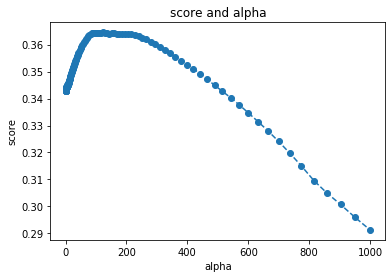

Lasso Linear Regression: The optimal alpha is  123.57946442779424 The max score is  0.3645986721973753


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
# We try to find the optimal alpha in this step, in the next step we will apply it into the train / test dataset
# split model_train dataset
lr_model_train, lr_model_validation = train_test_split(model_train, test_size = 0.15, random_state = 0) 
lr_model_train_x = lr_model_train.drop(['video_id','cvt_per_day'], axis =1)
lr_model_validation_x = lr_model_validation.drop(['video_id','cvt_per_day'], axis =1)
lr_model_train_y = lr_model_train['cvt_per_day']
lr_model_validation_y = lr_model_validation['cvt_per_day']

# alpha range
# alpha is a constant that multiplies the L1 term
alphas = np.logspace(-0.3,3,num=150)
# Return an array of ones with the same shape and type as given alphas array
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
# grid searching, find the optimal alpha and highest score
for i,a in enumerate(alphas):
  lasso = linear_model.Lasso()
  lasso.set_params(alpha=a)
  lasso.fit(lr_model_train_x,lr_model_train_y)
  # the score returns the coefficient of determination R^2 (1-u/v) of the prediction.
  # The best R^2 is 1
  scores[i] = lasso.score(lr_model_validation_x,lr_model_validation_y)
  if scores[i] > max_score:
    max_score = scores[i]
    opt_a = a
    best_lasso = lasso
# plot score and alpha
plt.plot(alphas,scores,linestyle='dashed',marker='o')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('score and alpha')
plt.show()
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.
print('Lasso Linear Regression: The optimal alpha is ', opt_a, 'The max score is ', max_score)


In [0]:
# Apply the optimal alpha into the train / test dataset, retrain the model
lasso_li = linear_model.Lasso()
lasso_li.set_params(alpha = opt_a)
lasso_li.fit(model_train_x,model_train_y)

Lasso(alpha=123.57946442779424, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

2)Polynomial features 




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34216404827.735252, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34320715202.97657, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34433821818.71084, tolerance: 48022560.445868425
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34555745768.

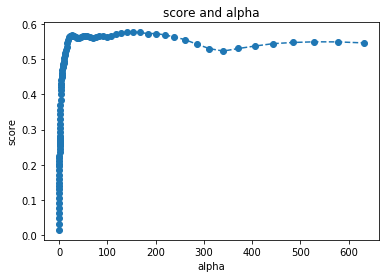

Lasso Polynomial: The optimal alpha is  153.41173650890957 The max score is  0.57642431701516


In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_model_train, lr_model_validation = train_test_split(model_train, test_size = 0.15, random_state = 0) 
lr_model_train_x = lr_model_train.drop(['video_id','cvt_per_day'], axis =1)
lr_model_validation_x = lr_model_validation.drop(['video_id','cvt_per_day'], axis =1)
lr_model_train_y = lr_model_train['cvt_per_day']
lr_model_validation_y = lr_model_validation['cvt_per_day']

lr_model_train_xp = poly.fit_transform(lr_model_train_x)
lr_model_validation_xp = poly.fit_transform(lr_model_validation_x)

alphas = np.logspace(-1,2.8,num=100)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
# grid searching, find the optimal alpha and highest score
for i,a in enumerate(alphas):
  lasso = linear_model.Lasso()
  lasso.set_params(alpha=a)
  lasso.fit(lr_model_train_xp,lr_model_train_y)
  scores[i] = lasso.score(lr_model_validation_xp,lr_model_validation_y)
  if scores[i] > max_score:
    max_score = scores[i]
    opt_a = a
    best_lasso = lasso
# plot score and alpha
plt.plot(alphas,scores,linestyle='dashed',marker='o')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('score and alpha')
plt.show()
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.
print('Lasso Polynomial: The optimal alpha is ', opt_a, 'The max score is ', max_score)


In [0]:
# Apply the optimal alpha into the train / test dataset, retrain the model
lr_train_xp1 = poly.fit_transform(model_train_x)
lasso_poly = linear_model.Ridge()
lasso_poly.set_params(alpha = opt_a)
lasso_poly.fit(lr_train_xp1,model_train_y)

Ridge(alpha=153.41173650890957, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

4.1.2 Ridge linear regression

1)All features are linear

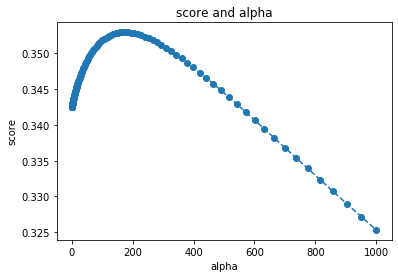

Ridge Linear Regression: The optimal alpha is  176.59559477043035 The max score is  0.35296977899760773


In [0]:
# We try to find the optimal alpha in this step, in the next step we will apply it into the train / test dataset
# split model_train dataset
rr_model_train, rr_model_validation = train_test_split(model_train, test_size = 0.15, random_state = 0) 
rr_model_train_x = rr_model_train.drop(['video_id','cvt_per_day'], axis =1)
rr_model_validation_x = rr_model_validation.drop(['video_id','cvt_per_day'], axis =1)
rr_model_train_y = rr_model_train['cvt_per_day']
rr_model_validation_y = rr_model_validation['cvt_per_day']

# alpha range
# alpha is a constant that multiplies the L2 term
alphas = np.logspace(-0.3,3,num=150)
# Return an array of ones with the same shape and type as given alphas array
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
# grid searching, find the optimal alpha and highest score
for i,a in enumerate(alphas):
  ridge = linear_model.Ridge()
  ridge.set_params(alpha=a)
  ridge.fit(rr_model_train_x,rr_model_train_y)
  # the score returns the coefficient of determination R^2 (1-u/v) of the prediction.
  # The best R^2 is 1
  scores[i] = ridge.score(rr_model_validation_x,rr_model_validation_y)
  if scores[i] > max_score:
    max_score = scores[i]
    opt_a = a
    best_ridge = ridge
# plot score and alpha
plt.plot(alphas,scores,linestyle='dashed',marker='o')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('score and alpha')
plt.show()
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.
print('Ridge Linear Regression: The optimal alpha is ', opt_a, 'The max score is ', max_score)

In [0]:
# Apply the optimal alpha into the train / test dataset, retrain the model
ridge_li = linear_model.Ridge()
ridge_li.set_params(alpha = opt_a)
ridge_li.fit(model_train_x,model_train_y)

Ridge(alpha=176.59559477043035, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

2)Polynomial features

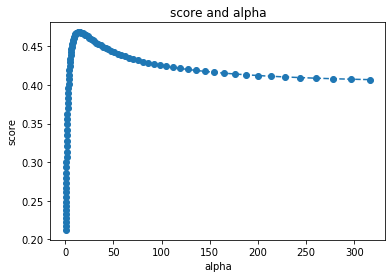

Ridge Polynomial: The optimal alpha is  14.81518471823528 The max score is  0.46814639322091167


In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

rr_model_train, rr_model_validation = train_test_split(model_train, test_size = 0.15, random_state = 0) 
rr_model_train_x = rr_model_train.drop(['video_id','cvt_per_day'], axis =1)
rr_model_validation_x = rr_model_validation.drop(['video_id','cvt_per_day'], axis =1)
rr_model_train_y = rr_model_train['cvt_per_day']
rr_model_validation_y = rr_model_validation['cvt_per_day']

rr_model_train_xp = poly.fit_transform(rr_model_train_x)
rr_model_validation_xp = poly.fit_transform(rr_model_validation_x)

alphas = np.logspace(-0.3,2.5,num=100)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
# grid searching, find the optimal alpha and highest score
for i,a in enumerate(alphas):
  ridge = linear_model.Ridge()
  ridge.set_params(alpha=a)
  ridge.fit(rr_model_train_xp,rr_model_train_y)
  scores[i] = ridge.score(rr_model_validation_xp,rr_model_validation_y)
  if scores[i] > max_score:
    max_score = scores[i]
    opt_a = a
    best_ridge = ridge
# plot score and alpha
plt.plot(alphas,scores,linestyle='dashed',marker='o')
plt.xlabel('alpha')
plt.ylabel('score')
plt.title('score and alpha')
plt.show()
# alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object.
print('Ridge Polynomial: The optimal alpha is ', opt_a, 'The max score is ', max_score)

In [0]:
# Apply the optimal alpha into the train / test dataset, retrain the model
rr_train_xp1 = poly.fit_transform(model_train_x)
ridge_poly = linear_model.Ridge()
ridge_poly.set_params(alpha = opt_a)
ridge_poly.fit(rr_train_xp1,model_train_y)

Ridge(alpha=14.81518471823528, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

**4.2 Nonlinear models**

Random Forest

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# rf_model_train, rf_model_validation = train_test_split(model_train, test_size = 0.15, random_state = 0) 
# rf_model_validation_x = rf_model_validation.drop(['video_id','cvt_per_day'], axis =1)
# rf_model_validation_y = rf_model_validation['cvt_per_day']

rf_model_train_x = model_train.drop(['video_id','cvt_per_day'], axis =1)
rf_model_train_y = model_train['cvt_per_day']

# store the random forest parameters used for grid search
parameters = {'n_estimators':[80,90,100,110], 'max_depth':[3,6,9,12,15,17]}
rf = RandomForestRegressor(random_state=0)
grid_rf = GridSearchCV(rf, parameters, cv=5)
grid_rf.fit(rf_model_train_x, rf_model_train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 6, 9, 12, 15, 17]

In [0]:
# get the best parameters
grid_rf.best_params_

{'max_depth': 12, 'n_estimators': 90}

In [0]:
grid_rf.cv_results_

{'mean_fit_time': array([0.37515407, 0.41725764, 0.46372128, 0.51262684, 0.65420637,
        0.73636212, 0.82088757, 0.89739861, 0.96404099, 1.08011127,
        1.20086889, 1.32330384, 1.28340678, 1.44005809, 1.59948697,
        1.76128149, 1.56858163, 1.76273108, 1.96708264, 2.1720459 ,
        1.72204661, 1.93579445, 2.14983401, 2.3656652 ]),
 'mean_score_time': array([0.00692863, 0.00743155, 0.00813909, 0.00859151, 0.00859666,
        0.00941529, 0.01000366, 0.01088338, 0.01065774, 0.01185737,
        0.01267729, 0.01374941, 0.01323686, 0.01462541, 0.01706166,
        0.0173667 , 0.01584735, 0.01761656, 0.01910262, 0.02114849,
        0.01730342, 0.01932335, 0.02104306, 0.02269092]),
 'mean_test_score': array([0.34468434, 0.34738242, 0.34532226, 0.34561066, 0.44669436,
        0.45123868, 0.44991573, 0.44918834, 0.46006836, 0.46241842,
        0.46210179, 0.46152925, 0.46981355, 0.47224949, 0.46865176,
        0.46660718, 0.46400432, 0.4672552 , 0.46609595, 0.46460621,
        0.466

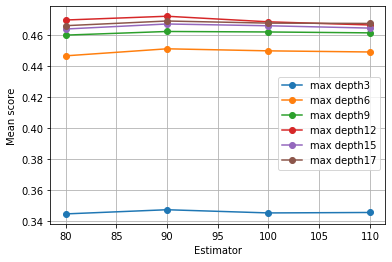

In [0]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
# because we use cross-validation here: cv=5, we need to retrieve mean score
scores = grid_rf.cv_results_['mean_test_score']
n_estimators = [80,90,100,110]
max_depth = [3,6,9,12,15,17]
scores = np.array(scores).reshape(len(max_depth), len(n_estimators))
fig = plt.figure()

for ind, i in enumerate(max_depth):
    plt.plot(n_estimators, scores[ind], '-o', label='max depth' + str(i))

plt.legend(bbox_to_anchor=(1, 0.7))

plt.xlabel('Estimator')
plt.ylabel('Mean score')
plt.grid(True)
plt.show()

In [0]:
rf = RandomForestRegressor(n_estimators=90,max_depth=12,random_state=0)
rf.fit(model_train_x,model_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

# **5. Model Evaluation**

We use test dataset here to evaluate different models.

**5.1 Lasso test with linear features**

In [0]:
# lasso linear regression score
lasso_li_score = lasso_li.score(model_test_x,model_test_y)
# predict cvt_per_day
pred_y = lasso_li.predict(model_test_x)

# calculate the MSE and RMSE between real target and predicted target
MSE_lasso_li = mean_squared_error(model_test_y,pred_y)
RMSE_lasso_li = sqrt(MSE_lasso_li)

print('Lasso Linear Regression''s Score is: ', lasso_li_score)
print('Lasso Linear Regression''s MSE is: ', MSE_lasso_li)
print('Lasso Linear Regression''s RMSE is: ', RMSE_lasso_li)


Lasso Linear Regressions Score is:  0.09930986035024358
Lasso Linear Regressions MSE is:  239016724.7670242
Lasso Linear Regressions RMSE is:  15460.165741900188


**5.2 Lasso test with polynomial features**

In [0]:
# poly fit x
model_test_xp = poly.fit_transform(model_test_x)
lasso_poly_score = lasso_poly.score(model_test_xp,model_test_y)
pred_y = lasso_poly.predict(model_test_xp)

# calculate the MSE and RMSE between real target and predicted target
MSE_lasso_poly = mean_squared_error(model_test_y,pred_y)
RMSE_lasso_poly = sqrt(MSE_lasso_poly)

print('Lasso Polynomial Regression''s Score is: ', lasso_poly_score)
print('Lasso Polynomial Regression''s MSE is: ', MSE_lasso_poly)
print('Lasso Polynomial Regression''s RMSE is: ', RMSE_lasso_poly)

Lasso Polynomial Regressions Score is:  0.3734079766624061
Lasso Polynomial Regressions MSE is:  166279130.40275168
Lasso Polynomial Regressions RMSE is:  12894.926537315041


**5.3 Ridge test with linear features**

In [0]:
ridge_li_score = ridge_li.score(model_test_x,model_test_y)
pred_y = ridge_li.predict(model_test_x)

# calculate the MSE and RMSE between real target and predicted target
MSE_ridge_li = mean_squared_error(model_test_y,pred_y)
RMSE_ridge_li = sqrt(MSE_ridge_li)

print('Ridge Linear Regression''s Score is: ', ridge_li_score)
print('Ridge Linear Regression''s MSE is: ', MSE_ridge_li)
print('Ridge Linear Regression''s RMSE is: ', RMSE_ridge_li)


Ridge Linear Regressions Score is:  0.11387665650808998
Ridge Linear Regressions MSE is:  235151124.6513715
Ridge Linear Regressions RMSE is:  15334.638067178876


**5.4 Ridge test with polynomial features**

In [0]:
# poly fit x
model_test_xp = poly.fit_transform(model_test_x)
ridge_poly_score = ridge_poly.score(model_test_xp,model_test_y)
pred_y = ridge_poly.predict(model_test_xp)

# calculate the MSE and RMSE between real target and predicted target
MSE_ridge_poly = mean_squared_error(model_test_y,pred_y)
RMSE_ridge_poly = sqrt(MSE_ridge_poly)

print('Ridge Polynomial Regression''s Score is: ', ridge_poly_score)
print('Ridge Polynomial Regression''s MSE is: ', MSE_ridge_poly)
print('Ridge Polynomial Regression''s RMSE is: ', RMSE_ridge_poly)

Ridge Polynomial Regressions Score is:  0.3817425582217332
Ridge Polynomial Regressions MSE is:  164067377.10500973
Ridge Polynomial Regressions RMSE is:  12808.878838720027


**5.5 Random forest test**

In [0]:
rf_score = rf.score(model_test_x,model_test_y)
pred_y = rf.predict(model_test_x)

MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(MSE_rf)

print('Random Forest''s Score is: ', rf_score)
print('Random Forest''s MSE is: ', MSE_rf)
print('Random Forest''s RMSE is: ', RMSE_rf)

Random Forests Score is:  0.6171357696886326
Random Forests MSE is:  101600928.3670583
Random Forests RMSE is:  10079.728585981782


**5.6 Compare the 5 models**

Plot r-square score, MSE and RMSE and compare the 5 models

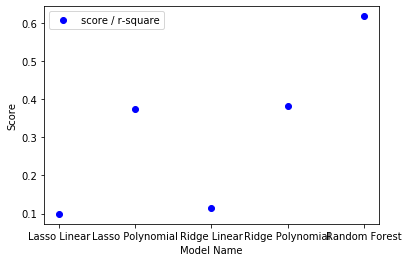

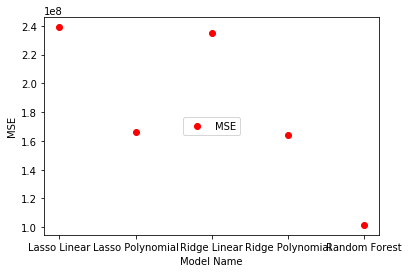

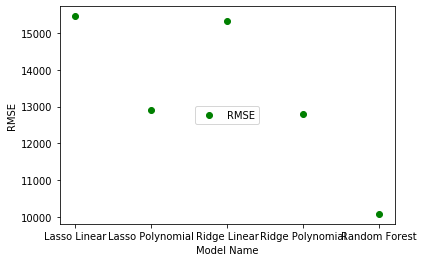

In [0]:
score_lst = [lasso_li_score, lasso_poly_score, ridge_li_score, ridge_poly_score, rf_score]
MSE_lst = [MSE_lasso_li, MSE_lasso_poly, MSE_ridge_li, MSE_ridge_poly, MSE_rf]
RMSE_lst = [RMSE_lasso_li, RMSE_lasso_poly, RMSE_ridge_li, RMSE_ridge_poly, RMSE_rf]
model_lst = ['Lasso Linear','Lasso Polynomial', 'Ridge Linear','Ridge Polynomial','Random Forest']

plt.figure()
plt.plot(model_lst,score_lst,'bo',label = 'score / r-square')
plt.legend(loc='upper left')
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.show()

plt.figure()
plt.plot(model_lst,MSE_lst,'ro',label = 'MSE')
plt.legend(loc='center')
plt.xlabel('Model Name')
plt.ylabel('MSE')
plt.show()

plt.figure()
plt.plot(model_lst,RMSE_lst,'go',label = 'RMSE')
plt.legend(loc='center')
plt.xlabel('Model Name')
plt.ylabel('RMSE')
plt.show()

Random forest has the highest score, lowest RSE and RMSE. So we can choose random forest.

# **6. Feature importance**

Because we choose random forest here, we can compute the relative importance of each attribute

Feature ranking:
1. feature 0 weighted_categorical_position (0.251483)
2. feature 2 imdb_votes (0.186643)
3. feature 1 weighted_horizontal_poition (0.139555)
4. feature 9 import_id_lionsgate (0.076530)
5. feature 8 star_category (0.051984)
6. feature 7 metacritic_score (0.051032)
7. feature 11 import_id_other (0.031201)
8. feature 4 boxoffice (0.027747)
9. feature 6 duration_in_mins (0.025317)
10. feature 5 imdb_rating (0.024617)
11. feature 3 budget (0.020389)
12. feature 28 Genres_Crime (0.010619)
13. feature 10 import_id_mgm (0.009561)
14. feature 23 awards_other award (0.005969)
15. feature 42 Genres_Thriller (0.005126)
16. feature 50 release_2006-2008 (0.004802)
17. feature 29 Genres_Documentary (0.004776)
18. feature 27 Genres_Comedy (0.004267)
19. feature 52 release_2010-2012 (0.003649)
20. feature 35 Genres_Kids & Family (0.003609)
21. feature 30 Genres_Drama (0.003498)
22. feature 40 Genres_Sci-Fi (0.003483)
23. feature 53 release_2012-2013 (0.003436)
24. feature 22 awards_no 

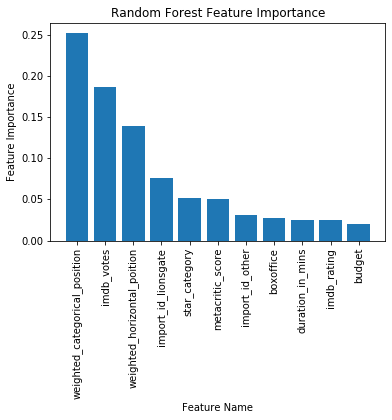

In [0]:
# feature importance
rf_feature_importance = rf.feature_importances_
# return the 'indirect' array of feature indices
indices = np.argsort(rf_feature_importance)[::-1]
# return the arry of model name 
feature_name = model_test_x.columns.array

print("Feature ranking:")

for f in range(model_test_x.shape[1]):
    print ("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_name[indices[f]], rf_feature_importance[indices[f]]))

plt.plot()
plt.bar(feature_name[indices[:11]],rf_feature_importance[indices[:11]])
plt.xlabel('Feature Name')
plt.xticks(rotation='vertical')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()